# Mask detection challenge
This notebook treats the <a hef="https://zindi.africa/competitions/zindiweekendz-learning-spot-the-mask-challenge/submissions">challenge</a> proposed in Zindi during the pandemic of coronavirus which consists of detecting the existence of a mask in a given image. 

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

In [2]:
#read the data
labels = pd.read_csv("train_labels.csv")

In [3]:
labels.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 2 columns):
image     1308 non-null object
target    1308 non-null int64
dtypes: int64(1), object(1)
memory usage: 20.6+ KB


In [5]:
dataset_size = len(labels)

In [6]:
dataset_size

1308

In [7]:
#select 5 different examples from each class
mask_on = []
mask_off = []
for i in range(dataset_size):
    if(labels["target"][i]==1 and len(mask_on)<5):
        mask_on.append(labels['image'].iloc[i])
    if(labels["target"][i]==0 and len(mask_off)<5):
        mask_off.append(labels['image'].iloc[i])

In [8]:
print("Images with mask on :",mask_on)
print("Images with mask off :",mask_off)

Images with mask on : ['rxgismgsvmaayzjarbfjaljhqmpbrt.jpg', 'rlbmuajgezfiddjzlyeoupxpqubkpt.jpg', 'qlwbzgvdyqwncrvqzaezrrqlwuugdp.jpg', 'eqirckpknxclvrlxvfxaswsodbxlmm.jpg', 'hpnmywojyjwgptgkflzydzenfxbtlr.png']
Images with mask off : ['tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg', 'uuzshfrhkgrkolhwdvliqauzulurnz.jpg', 'mjspxsagzusaznvnyxgamtrlqkqklp.jpg', 'ngvvhadzegowlxligtftkbucwyphvw.jpg', 'lbbmpcbdwgdbskcdmsanklchyknuig.jpg']


In [9]:
#path where the images are stored
images_path = "images/"

In [10]:
#function to show the given examples
def show_exemples(mask_on, mask_off):
    fig, axes = plt.subplots(nrows=2, ncols= len(mask_on) , figsize=(16,8))
    for i in range(len(mask_on)):
        image_name = mask_on[i]
        img = cv2.imread(images_path+image_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0][i].imshow(img)
    for i in range(len(mask_off)):
        image_name = mask_off[i]
        img = cv2.imread(images_path+image_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1][i].imshow(img)
    plt.show()

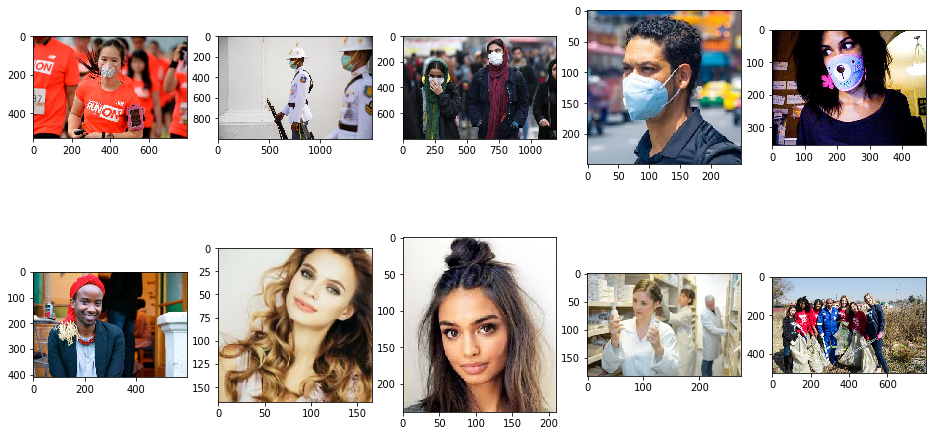

In [11]:
show_exemples(mask_on, mask_off)

In [12]:
# paths 
train_path="train_images/"
val_path="val_images/"
train_path_mask_on = "train_images/mask_on/"
train_path_mask_off = "train_images/mask_off/"
val_path_mask_on = "val_images/mask_on/"
val_path_mask_off = "val_images/mask_off/"

In [13]:
#function to copy an image from src to dest
def copy(src , dest):
    img = cv2.imread(src)
    cv2.imwrite(dest,img)

In [14]:
# size of training set
split_size = int(dataset_size*0.8)

In [15]:
train_size = split_size
val_size = dataset_size -train_size

In [16]:
num_train_mask_on = len(list(os.listdir(train_path_mask_on)))
num_train_mask_off = len(list(os.listdir(train_path_mask_off)))
num_val_mask_on = len(list(os.listdir(val_path_mask_on)))
num_val_mask_off = len(list(os.listdir(val_path_mask_off)))
print("{} images with mask on and {} images with mask off in the training set".format(num_train_mask_on,num_train_mask_off))
print("{} images with mask on and {} images with mask off in the validation set".format(num_val_mask_on,num_val_mask_off))

508 images with mask on and 538 images with mask off in the training set
136 images with mask on and 126 images with mask off in the validation set


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [18]:
#define the training generator and the validation generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1046 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


In [19]:
train_generator.class_indices

{'mask_off': 0, 'mask_on': 1}

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [21]:
#function to return the defined model
def get_model():
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))
    for layer in inception.layers:
        layer.trainable=False
    outputs = inception.get_layer("mixed5").output
    flat = tf.keras.layers.Flatten()(outputs)
    dense1 = tf.keras.layers.Dense(512 , activation="relu")(flat)
    drop1 = tf.keras.layers.Dropout(0.2)(dense1)
    dense2 = tf.keras.layers.Dense(256 , activation="relu")(drop1)
    drop2 = tf.keras.layers.Dropout(0.2)(dense2)
    output = tf.keras.layers.Dense(1, activation="sigmoid",kernel_regularizer='l2')(drop2)

    model = Model(inception.inputs, output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [22]:
model = get_model()

In [23]:
#model.summary()

In [24]:
batch_size=32
steps_per_epoch = train_size//batch_size
epochs=2 ## epochs = 7-8 gave me nice predctions , but i put 2 just to accelerate
validation_steps=val_size//batch_size

In [25]:
#train the model
model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 8 steps
Epoch 1/2
32/32 [==============================] - 369s 12s/step - loss: 2.0693 - accuracy: 0.6026 - val_loss: 0.5626 - val_accuracy: 0.7383
Epoch 2/2
32/32 [==============================] - 288s 9s/step - loss: 0.4823 - accuracy: 0.7968 - val_loss: 0.4450 - val_accuracy: 0.7930


In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [32]:
#get the testing set
test_labels = pd.read_csv('sample_sub_v2.csv')

In [33]:
test_labels.head()

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0


In [34]:
targets = []
for i in range(len(test_labels)):
    image_name = test_labels["image"][i]
    img = load_img(images_path+image_name, target_size=(150,150,3)) # load the image
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr]) 
    input_arr = input_arr*(1./255)
    targets.append(loaded_model.predict(input_arr)) ## predict the probability 

In [35]:
targets = np.array(targets) # convert to numpy array

In [36]:
targets = targets.reshape(len(test_labels))# reshape to 1D array

In [37]:
#print(targets)

In [38]:
sub = pd.DataFrame({"image":test_labels["image"].values, "target":(targets>0.5).astype(int)}) # create the submission dataframe

In [39]:
sub.head()

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,1
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0


In [40]:
sub.to_csv('submission.csv', index=False) ## save the submission dataframe